In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [3]:
# Load datasets
movies = pd.read_csv("/content/tmdb_5000_credits.csv")
credits = pd.read_csv("/content/tmdb_5000_movies.csv")

In [4]:
# Merge on 'title'
movies = movies.merge(credits, left_on='title', right_on='title')


# Select useful columns
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]


# Drop missing values
movies.dropna(inplace=True)

In [8]:
# Function to convert stringified JSON to list of names
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L


# Function to extract top 3 actors
def convert_cast(obj):
    L = []
    count = 0
    for i in ast.literal_eval(obj):
        if count < 3:
            L.append(i['name'])
            count += 1
        else:
            break
    return L


IndentationError: expected an indented block after function definition on line 21 (ipython-input-1447833699.py, line 22)

In [9]:
# Function to extract director
def fetch_director(obj):
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            return [i['name']]
    return []

In [10]:
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(convert_cast)
movies['crew'] = movies['crew'].apply(fetch_director)


# Convert overview into list
movies['overview'] = movies['overview'].apply(lambda x: x.split())


# Remove spaces from multi-word names
movies['genres'] = movies['genres'].apply(lambda x: [i.replace(" ", "") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
movies['cast'] = movies['cast'].apply(lambda x: [i.replace(" ", "") for i in x])
movies['crew'] = movies['crew'].apply(lambda x: [i.replace(" ", "") for i in x])


# Create tags column
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']


new_df = movies[['movie_id', 'title', 'tags']]


# Join list into string
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

/tmp/ipython-input-3864540945.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))


In [14]:
# Text vectorization
cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(new_df['tags']).toarray()


# Cosine similarity
similarity = cosine_similarity(vectors)


# Recommendation function with visualization
def recommend(movie):
    if movie not in new_df['title'].values:
        print("Movie not found in dataset.")
        return

    movie_index = new_df[new_df['title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]

    print("Top 5 recommendations for:", movie)
    recommended_titles = []
    scores = []
    for i in movies_list:
        title = new_df.iloc[i[0]].title
        score = i[1]
        recommended_titles.append(title)
        scores.append(score)
        print(title, " (Similarity:", round(score, 3), ")")

    # Visualization: Bar chart of similarity scores
    plt.figure(figsize=(8,5))
    plt.barh(recommended_titles[::-1], scores[::-1], color='skyblue')
    plt.xlabel("Cosine Similarity Score")
    plt.title(f"Top 5 Recommendations for '{movie}'")
    plt.show()

Top 5 recommendations for: Avatar
Titan A.E.  (Similarity: 0.25 )
Small Soldiers  (Similarity: 0.248 )
Independence Day  (Similarity: 0.243 )
Ender's Game  (Similarity: 0.241 )
Aliens vs Predator: Requiem  (Similarity: 0.239 )


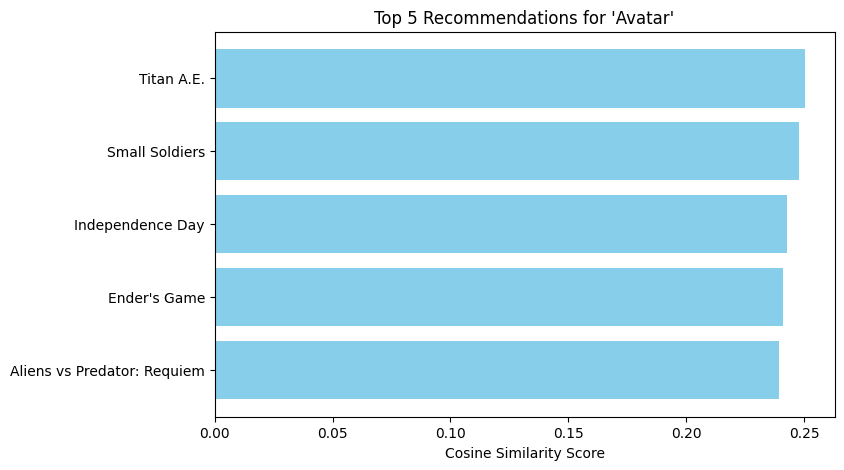

In [18]:
recommend('Avatar')
